In [1]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
carrier_mapper = {
    "PHS": "hydro",
    "hydro-scheme": "hydro",
    "hydro": "hydro",
    "dam": "hydro",
    "PHS": "hydro",
    "floating wind": "wind",
    "onwind": "wind",
    "wind": "wind",
    "offwind": "wind",
    "CCGT": "gas",
    "CHP": "gas",
    "biomass": "biomass",
    "gas": "gas",
    "gas-fired": "gas",
    "gas turbine": "gas",
    "coal": "coal",
    "powerstation": "gas",
    "cascade": "gas",
    "nuclear": "nuclear",
    "battery": "battery",
    'interconnector': 'imports',
    'PV': 'solar',
    'solar power station': 'solar',
}

In [3]:
carrier_colors = {
    "wind": "#7ac677",
    "offshore wind": "#6895dd",
    "hydro": "purple",
    "coal": "#454546",
    "biomass": "#dbc263",
    "gas": "#f6986b",
    "nuclear": '#549ca2',
    "imports": "#dd75b0",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": 'turquoise',
}

In [5]:
bids = []
offers = []

start = pd.Timestamp('2022-01')
end = pd.Timestamp('2022-07-01')

for d in os.listdir(Path.cwd().parent / 'data' / 'base'):

    # ts = pd.Timestamp(d)
    # if ts < start or ts > end:
    #     continue

    try:
        bids.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / d / 'bids.csv', index_col=[0,1]
            )
        )

        offers.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

offers = pd.concat(offers)
bids = pd.concat(bids)

In [8]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'temp_located_bmus.csv', index_col=0)
# bmus = bmus.loc[bmus['lat'] != 0]

bmus.carrier.unique()

array([nan, 'interconnector', 'supply', 'battery', 'gas-fired', 'gas',
       'onwind', 'hydro', 'hydro-scheme', 'wind', 'biomass', 'offwind',
       'CHP', 'CCGT', 'floating wind', 'oil', 'coal',
       'submarine power cable', 'gas turbine', 'powerstation', 'cascade',
       'steel mill', 'business', 'PV', 'PHS', 'nuclear', 'dam',
       'solar power station', 'natural gas processing'], dtype=object)

In [9]:
idx = pd.IndexSlice

bid_prices = bids.loc[idx[:,'price'],:]
offer_prices = offers.loc[idx[:,'price'],:]
# bid_vols = bids.loc[idx[:,'vol'],:]

bid_acceptances = len(bid_prices) - bid_prices.isna().sum()
offer_acceptances = len(offer_prices) - offer_prices.isna().sum()

thresh = 48

bid_acceptances = bid_acceptances.loc[bid_acceptances > thresh].index
offer_acceptances = offer_acceptances.loc[offer_acceptances > thresh].index


In [10]:
offer_stats = pd.concat((
    offer_prices.mean().rename('mean'),
    offer_prices.std().rename('std')),
    axis=1).loc[offer_acceptances]
offer_stats = offer_stats.loc[offer_stats.index.intersection(bmus.index)]

bid_stats = pd.concat((
    bid_prices.mean().rename('mean'),
    bid_prices.std().rename('std')),
    axis=1).loc[bid_acceptances]
bid_stats = bid_stats.loc[bid_stats.index.intersection(bmus.index)]

In [11]:
offer_stats['carrier'] = list(map(lambda name: bmus.loc[name, 'carrier'], offer_stats.index))
bid_stats['carrier'] = list(map(lambda name: bmus.loc[name, 'carrier'], bid_stats.index))

missing:  nan
missing:  oil
missing:  nan
missing:  oil


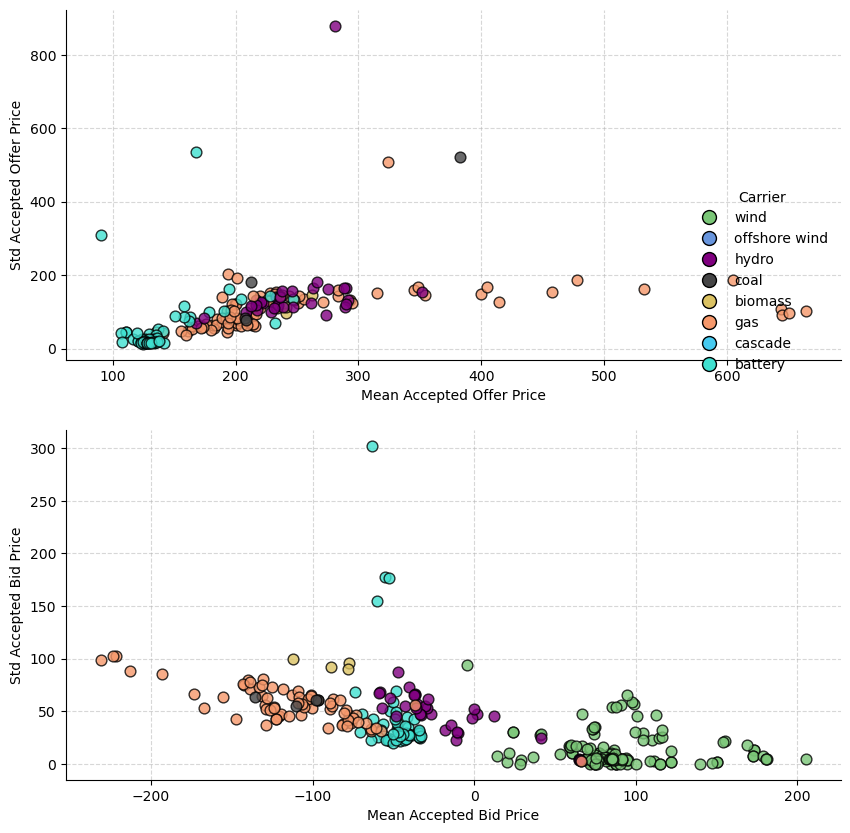

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

scatter_kwargs = {
    's': 60,
    'alpha': 0.8,
    'edgecolors': 'black',
    'linewidths': 1,
}

for df, ax in zip([offer_stats, bid_stats], axs):

    for carrier in df['carrier'].unique():

        ss = df.loc[df.carrier == carrier]

        try:
            ax.scatter(
                ss['mean'],
                ss['std'],
                label=carrier,
                color=carrier_colors[carrier_mapper[carrier]],
                **scatter_kwargs
                )
        except KeyError:
            print('missing: ', carrier)
            pass

    handles, labels = [], []
    for name, color in carrier_colors.items():

        if name in ['solar', 'imports', 'nuclear']:
            continue

        handles.append(
            plt.Line2D(
                [0], [0], marker='o',
                color='w',
                markerfacecolor=color,
                markersize=10,
                markeredgewidth=1,
                markeredgecolor='black'
                )
            )
        labels.append(name)
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[1].legend(
    handles,
    labels,
    bbox_to_anchor=(1.0, 1.72),
    frameon=False,
    title='Carrier',
)


axs[1].set_xlabel('Mean Accepted Bid Price')
axs[1].set_ylabel('Std Accepted Bid Price')

axs[0].set_xlabel('Mean Accepted Offer Price')
axs[0].set_ylabel('Std Accepted Offer Price')

plt.show()

In [270]:
bid_stats.loc[bid_stats['std'] < 1]

,mean,std,carrier
CLDCW-1,74.690000,5.261150e-13,onwind
CRDEW-1,49.818129,4.822903e-01,onwind
CRDEW-2,49.841410,4.535826e-01,onwind
CLDNW-1,74.580000,1.137712e-12,onwind
CLDSW-1,76.620000,3.273831e-13,onwind
AKGLW-3,48.760000,3.554573e-13,onwind
STLGW-1,81.520000,3.561549e-13,onwind
STLGW-2,81.520000,3.559901e-13,onwind
STLGW-3,81.520000,3.698467e-13,onwind
AKGLW-2,71.000000,6.558468e-16,onwind


In [230]:
import numpy as np

start = pd.Timestamp('2024-05-03 16:12:00')
date = pd.Timestamp('2024-11-01 18:30:00')

print(date - start)

"{}%".format(np.around(100 * (date - start) / pd.Timedelta('365D'), decimals=2))

182 days 02:18:00


'49.89%'

In [83]:
stats.query('carrier == "hydro"')

,mean,std,carrier
FASN-1,-3.877856,42.346488,hydro
FASN2,-10.384845,42.246930,hydro
FASN3,-8.738520,36.006845,hydro
CLAC-1,-12.062609,42.174285,hydro
FINL-1,-38.377092,66.830766,hydro
NANT-1,-53.592254,44.998400,hydro
SLOY-1,-37.693966,43.863859,hydro
SLOY-2,-36.162281,42.671025,hydro
SLOY-3,-37.413043,44.550546,hydro
SLOY-4,-28.641975,33.713057,hydro


In [85]:
stats.query('carrier == "battery"')

,mean,std,carrier
COWB-1,-91.545867,42.365062,battery
AG-HEL00G,-52.856459,56.254912,battery
ARNKB-1,-66.154423,49.776201,battery
AG-MSTK01,-112.234686,21.973943,battery


In [194]:
pn = []

for d in os.listdir(Path.cwd().parent / 'data' / 'base'):

    try:
        pn.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / d / 'physical_notifications.csv', index_col=0
                # Path.cwd().parent / 'data' / 'base' / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

pn = pd.concat(pn)

In [195]:
exporter_mask = (pn > 0).any()
importer_mask = (pn < 0).any()

# import must make up within tolerance share of total bum activity
lower_tolerance = 0.1
upper_tolerance = 0.9

total_import = pn.clip(upper=0).abs().sum()
total_export = pn.clip(lower=0).sum()

balanced = (total_import / (total_export + total_import)).between(lower_tolerance, upper_tolerance)

# flex_assets = pn.loc[:, exporter_mask & importer_mask]
flex_assets = pn.loc[:, balanced]

In [196]:
(fx := pn[flex_assets.columns].abs().sum().sort_values(ascending=False)).head(20)

DINO-6       685965.433333
DINO-5       559538.600000
DINO-4       419940.516667
DINO-3       355116.666667
DINO-2       347263.750000
MNW-PGU01    266781.000000
EAS-PGU01    262144.000000
YEP-PGU01    237090.000000
SEE-PGU01    232216.000000
LON-PGU01    215852.000000
FOYE-1       198873.366667
WILCT-1      184973.500000
NEE-PGU01    173634.000000
FOYE-2       152614.650000
STH-SEL01    141830.000000
SSC-PGU01    111656.000000
CRUA-2       106527.466667
FFES-2       104722.283333
FFES-1        71800.300000
SWA-PGU01     68721.000000
dtype: float64